In [1]:
import json
import torch
import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import data_utils
import utils
import linear_explanation

## Settings

In [2]:
target_name = "resnet50_imagenet"
device = "cuda"
dataset_name = "imagenet_val"
target_layer = "layer4"
target_neuron = 136
batch_size = 256
save_dir = 'saved_activations'

model, preprocess = data_utils.get_target_model(target_name, device=device)

## Run required results

In [3]:
dataset = data_utils.get_data(dataset_name, preprocess)
layer_save_path = '{}/{}_{}/{}/'.format(save_dir, target_name, dataset_name, target_layer)

activations = utils.save_summary_activations(model, dataset, device, target_layer, batch_size, layer_save_path)
summary_activations = activations[:, target_neuron]
summary_activations.shape

torch.Size([50000])

### Load results

In [4]:
le_label_results = pd.read_csv("results/ours/le_label/resnet50_imagenet_layer4.csv")
le_label_results = le_label_results[le_label_results["unit"]==target_neuron]
one_hot_labels, concept_text = linear_explanation.get_onehot_labels(dataset_name, device)

In [5]:
concepts = []
for i in range(10):
    concept = str(le_label_results["concept{}".format(i)].iloc[0])
    if str(concept) != "0":
        concepts.append(concept)

max_activation = float(torch.max(summary_activations).cpu())
print(max_activation)
print(concepts)

5.703125
['snowmobile', 'ski', 'sled', 'balaclava ski mask', 'hound', 'canine']


In [16]:
nums = [i*0.125*max_activation for i in range(9)]

frac_by_concept = {}
for concept in concepts:
    frac_by_concept[concept] = []
frac_by_concept["other"] = []

other = torch.ones(len(one_hot_labels)).to(device)
for concept in concepts:
    id = concept_text.index(concept)
    other = torch.clip(other-(one_hot_labels[:, id]), min=0)
    
for i in range(1, len(nums)):
    print("{} =< Act < {}:".format(nums[i-1], nums[i]))
    indices = (summary_activations <= nums[i])*(summary_activations > nums[i-1])
    print("{} inputs".format(int(torch.sum(indices))))
    fraction = torch.mean(one_hot_labels[indices], dim=0)
    
    for concept in concepts:
        id = concept_text.index(concept)
        frac_by_concept[concept].append(fraction[id].cpu().numpy()*100)
        print("{} - {:.2f}%".format(concept, fraction[id].cpu()*100))
        
    frac_by_concept["other"].append(other[indices].mean().cpu().numpy()*100)

0.0 =< Act < 0.712890625:
42873 inputs
snowmobile - 0.00%
ski - 0.01%
sled - 0.01%
balaclava ski mask - 0.01%
hound - 0.91%
canine - 9.46%
0.712890625 =< Act < 1.42578125:
5738 inputs
snowmobile - 0.05%
ski - 0.05%
sled - 0.45%
balaclava ski mask - 0.23%
hound - 6.88%
canine - 32.59%
1.42578125 =< Act < 2.138671875:
819 inputs
snowmobile - 0.37%
ski - 0.61%
sled - 1.83%
balaclava ski mask - 1.71%
hound - 16.73%
canine - 58.97%
2.138671875 =< Act < 2.8515625:
170 inputs
snowmobile - 8.82%
ski - 5.88%
sled - 15.88%
balaclava ski mask - 4.12%
hound - 12.94%
canine - 37.06%
2.8515625 =< Act < 3.564453125:
74 inputs
snowmobile - 12.16%
ski - 16.22%
sled - 20.27%
balaclava ski mask - 5.41%
hound - 6.76%
canine - 16.22%
3.564453125 =< Act < 4.27734375:
46 inputs
snowmobile - 34.78%
ski - 19.57%
sled - 23.91%
balaclava ski mask - 8.70%
hound - 2.17%
canine - 2.17%
4.27734375 =< Act < 4.990234375:
15 inputs
snowmobile - 20.00%
ski - 33.33%
sled - 20.00%
balaclava ski mask - 20.00%
hound - 0.00%

In [17]:
for concept in frac_by_concept.keys():
    frac_by_concept[concept] = np.array(frac_by_concept[concept])

frac_by_concept["other canine"] = frac_by_concept["canine"] - frac_by_concept["hound"]

In [18]:
x_values = [0]

for i, num in enumerate(nums[1:]):
    x_values.append((nums[i]+num)/2)
x_values.append(nums[-1])

for concept in frac_by_concept:
    frac_by_concept[concept] = np.pad(frac_by_concept[concept], pad_width=1, mode="edge")

snowmobile
ski
sled
balaclava ski mask
hound
other canine
other


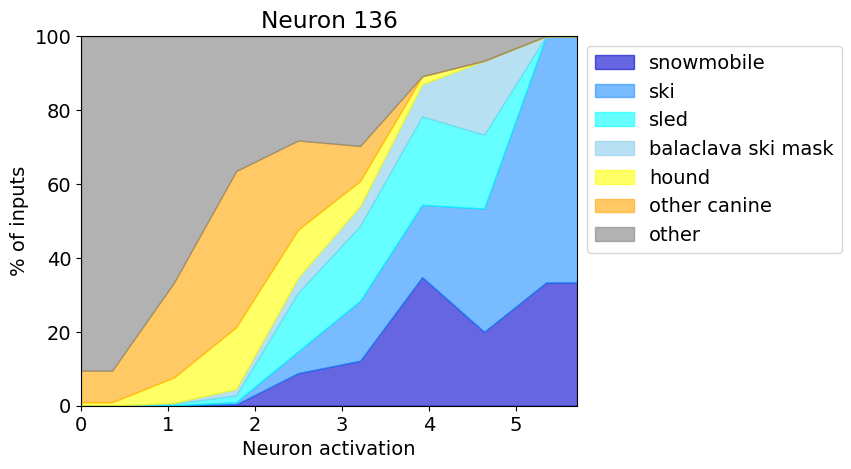

In [19]:
font = {'size'   : 14}
matplotlib.rc('font', **font)

concepts_to_plot = ['snowmobile', 'ski', 'sled', 'balaclava ski mask', 'hound', 'other canine', 'other']
#colors = ["skyblue", "orange", "forestgreen", "grey"]
#colors = ["pink", "orangered", "red", "maroon", "skyblue", "mediumblue", "grey"]
colors = ["mediumblue", "dodgerblue", "cyan", "skyblue", "yellow", "orange", "grey"]

cum_fractions = [np.zeros(len(x_values))]
for i, concept in enumerate(concepts_to_plot):
    print(concept)
    cum_fractions.append(cum_fractions[i]+frac_by_concept[concept])

for i, concept in enumerate(concepts_to_plot):
    plt.fill_between(x_values, cum_fractions[i], cum_fractions[i+1], color=colors[i], alpha=0.6, label=concepts_to_plot[i])

# Customize the plot
plt.xlabel('Neuron activation')
plt.ylabel('% of inputs')
plt.title('Neuron {}'.format(target_neuron))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xlim(np.min(x_values), np.max(x_values))
plt.ylim(0, np.max(cum_fractions))
# Show the plot
plt.show()